In [1]:
import gym
from tensorflow import keras
from tensorflow.keras.optimizers.legacy import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt

import numpy as np

from env.env import KeibaEnv

# ゲーム環境を作成します
env = KeibaEnv(
    "./../data/train/2003_ranking_without_g.csv",
    "./../data/train/2003_result.csv"
)

# ゲーム環境を初期化します。
observation = env.reset()

# 環境からアクション数を取得します。このゲームでは4となります。
nb_actions = env.action_space.n

try:
    model = keras.models.load_model('./../model/ranking_model_without_g')
except:
    print("create")
    # Kerasを使ってモデルを作成します。
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(1,) + env.observation_space.shape),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(nb_actions, activation="softmax"),
    ])

# 経験値を蓄積するためのメモリです。学習を安定させるために使用します。
memory = SequentialMemory(limit=50000000, window_length=1)

# 行動ポリシーはBoltzmannQPolicyを使用しています。
# EpsGreedyQPolicyと比較して、こちらの方が収束が早かったので採用しています。
policy = EpsGreedyQPolicy()

# DQNAgentを作成します。
dqn = DQNAgent(
    model=model,
    nb_actions=nb_actions,
    memory=memory,
    target_model_update=1e-2,
    policy=policy)

# DQNAgentのコンパイル。最適化はAdam,評価関数はMAEを使用します。
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

# 学習を開始します。100000ステップ実行します。
history = dqn.fit(env, nb_steps=200000, visualize=False, verbose=1)



RANK_ONE_HORSE: 0
RANK_TWO_HORSE: 0
RANK_THREE_HORSE: 0
RANK_FOUR_HORSE: 0
RANK_FIVE_HORSE: 0
NO_ACITON: 0

create
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Training for 200000 steps ...

RANK_ONE_HORSE: 0
RANK_TWO_HORSE: 0
RANK_THREE_HORSE: 0
RANK_FOUR_HORSE: 0
RANK_FIVE_HORSE: 0
NO_ACITON: 0

Interval 1 (0 steps performed)
   59/10000 [..............................] - ETA: 26s - reward: 376.2712

C:\Users\kazuy\anaconda3\envs\keiba_ai_learning2\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  994/10000 [=>............................] - ETA: 22s - reward: -116.9014

C:\Users\kazuy\anaconda3\envs\keiba_ai_learning2\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


 3319/10000 [========>.....................] - ETA: 43s - reward: -97.7409
RANK_ONE_HORSE: 1301
RANK_TWO_HORSE: 68
RANK_THREE_HORSE: 1794
RANK_FOUR_HORSE: 43
RANK_FIVE_HORSE: 58
NO_ACITON: 59

 6645/10000 [==================>...........] - ETA: 25s - reward: -158.0742
RANK_ONE_HORSE: 1293
RANK_TWO_HORSE: 62
RANK_THREE_HORSE: 1798
RANK_FOUR_HORSE: 54
RANK_FIVE_HORSE: 57
NO_ACITON: 59

 9965/10000 [============================>.] - ETA: 0s - reward: -132.1931
RANK_ONE_HORSE: 1299
RANK_TWO_HORSE: 52
RANK_THREE_HORSE: 1813
RANK_FOUR_HORSE: 58
RANK_FIVE_HORSE: 53
NO_ACITON: 48

10000/10000 [==============================] - 80s 8ms/step - reward: -132.9704
3 episodes - episode_reward: -440434.667 [-721501.000, -269901.000] - loss: 18288001.110 - mae: 282.573 - mean_q: 1.000

Interval 2 (10000 steps performed)
 2568/10000 [======>.......................] - ETA: 1:05 - reward: -106.4256done, took 102.595 seconds


INFO:tensorflow:Assets written to: ./../model/ranking_model_without_g\assets


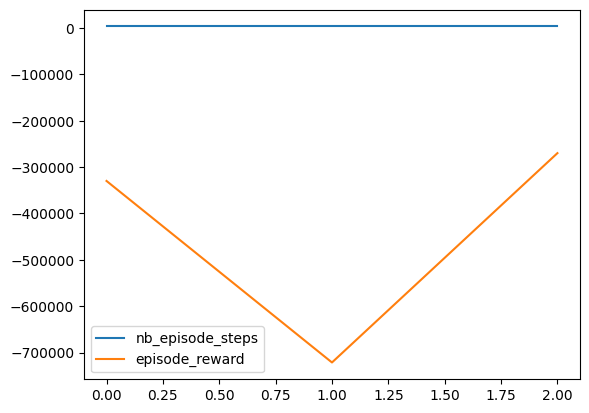

In [2]:
# 学習した重みをファイルに保存します。
#dqn.save_weights('moving_test.hdf5', overwrite=True)

# 学習したモデルを保存
model.save("./../model/ranking_model_without_g")

# ゲームごとのステップ数と報酬をグラフ化します。
plt.plot(history.history['nb_episode_steps'], label='nb_episode_steps')
plt.plot(history.history['episode_reward'], label='episode_reward')
plt.legend()
plt.show()